In [1]:
import sys
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import matplotlib.pyplot as plt 
sys.path.append('./sources')
from models import predict_knn, predict_LDMM, predict_SAME, predict_AMD
from preprocessing import dao

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline   
%load_ext autoreload
%autoreload 2
l2 = True

### Loading data

In [2]:
data = pd.read_csv('data/nn3.csv')

In [3]:
data = data.loc[~data.isna().sum(1).astype(bool), :]
data = data[data['Start Year'] == 1982]
data = data[data['Dataset'] == 'complete']
data = data.drop(columns=data.columns[:6])
data = data.transpose()

In [4]:
data = data.to_numpy()[:,1:].astype(np.float)

In [5]:
#Excluding seasonability 
timestamps = np.arange(data.shape[0])
# mask = np.tile(np.append(np.ones(1), np.append(np.zeros(10), np.ones(1))), 20)[:-2]
# timestamps = timestamps[mask==0]
# data = data[mask==0]
for i in range(data.shape[1]):
      data[:, i] = dao(data[:, i])  
#     data[:, i], _ = boxcox(data[:, i])

### Setting parameters

In [6]:
num_series = data.shape[1]
# Number of test months
n_test = 100
# LDMM parameters
h_sqr = 0.001
bandwidth_ldmm, lambd_ldmm, mu, n_iter_ldmm = 11, h_sqr / 7.0, 1500.0,  7
# nn_ldmm = 15
# SAME parameters
bandwidth_same, tau, n_iter_same = 3, 1.0, 21
# nn_same = 15
# kNN parameters
bandwidth_knn = 12
# nn_knn = 15
# ADM parameters
lambd_adm = 3.
# nn_adm = 15
n_iter_adm = 3

In [7]:
losses_ldmm, losses_ldmm_l1 = [], []
losses_same, losses_same_l1 = [], []
losses_knn, losses_knn_l1 = [], []
losses_adm, losses_adm_l1 = [], []
candidates = [1, 5, 9, 20]
for n_neighbors in candidates:
    nn_ldmm = n_neighbors
    nn_same = n_neighbors
    nn_knn = n_neighbors
    nn_adm = n_neighbors
    lookfront = 1
    predictions_knn   = np.empty((n_test, lookfront, num_series))
    predictions_ldmm  = np.empty((n_test, lookfront, num_series))
    predictions_same  = np.empty((n_test, lookfront, num_series))
    predictions_arima = np.empty((n_test, lookfront, num_series))
    predictions_adm = np.empty((n_test, lookfront, num_series))

    outcomes = np.empty((n_test, lookfront, num_series))
    for i in range(n_test):

        Y_train_knn   = data[:-n_test+i+1-lookfront, :]
        Y_train_ldmm  = data[:-n_test+i+1-lookfront, :]
        Y_train_same  = data[:-n_test+i+1-lookfront, :]
        Y_train_arima = data[:-n_test+i+1-lookfront, :]
        Y_train_adm = data[:-n_test+i+1-lookfront, :]

        for k in range(lookfront):
            timestamps_train = timestamps[:-n_test+i+1-lookfront+k]
            timestamp_test = timestamps[-n_test+i+1-lookfront+k]
            Y_test = data[-n_test+i+1-lookfront+k, :]

            predictions_knn[i, k, :] = predict_knn(timestamps_train, Y_train_ldmm, timestamp_test,\
                                                   bandwidth_knn, nn_knn)[:]
            predictions_ldmm[i, k, :] = predict_LDMM(timestamps_train, Y_train_ldmm, timestamp_test,\
                                                    bandwidth_ldmm, lambd_ldmm, mu, h_sqr, n_iter_ldmm, nn_ldmm)[:]
            predictions_same[i, k, :] = predict_SAME(timestamps_train, Y_train_same, timestamp_test,\
                                                    bandwidth_same, tau, n_iter_same, nn_same)[:]
            predictions_adm[i, k, :] = predict_AMD(timestamps_train, Y_train_same, timestamp_test,\
                                                    bandwidth_same, lambd_adm, n_iter_adm, nn_adm)[:]
            for t in range(num_series):
                arima_model = ARIMA(Y_train_arima[:, t], order=(6,1,0))
                predictions_arima[i, k, t] = arima_model.fit().forecast(steps=1)[0] 


            outcomes[i, k, :] = Y_test[:]
            Y_train_knn = np.append(Y_train_knn, predictions_knn[i, k, :].reshape(1,-1), axis=0)
            Y_train_ldmm = np.append(Y_train_ldmm, predictions_ldmm[i, k, :].reshape(1,-1), axis=0)
            Y_train_same = np.append(Y_train_same, predictions_same[i, k, :].reshape(1,-1), axis=0)
            Y_train_arima = np.append(Y_train_arima, predictions_arima[i, k, :].reshape(1,-1), axis=0)
            Y_train_adm = np.append(Y_train_arima, predictions_arima[i, k, :].reshape(1,-1), axis=0)


    new_loss_knn = np.mean((predictions_knn[:,-1]-outcomes[:,-1])**2/ outcomes[:,-1]**2, axis=0)
    new_loss_ldmm = np.mean((predictions_ldmm[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_same = np.mean((predictions_same[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_arima = np.mean((predictions_arima[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_adm = np.mean((predictions_adm[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)

    new_loss_knn_l1= np.mean(np.abs(predictions_knn[:,-1]-outcomes[:,-1])/ np.abs(outcomes[:,-1]), axis=0)
    new_loss_ldmm_l1 = np.mean(np.abs(predictions_ldmm[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_same_l1 = np.mean(np.abs(predictions_same[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_arima_l1 = np.mean(np.abs(predictions_arima[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_adm_l1 = np.mean(np.abs(predictions_adm[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    
    print(lookfront)
    print('knn {:.3f} {:.3f}'.format(np.mean(new_loss_knn), np.mean(new_loss_knn_l1)))
    print('ldmm {:.3f} {:.3f}'.format(np.mean(new_loss_ldmm), np.mean(new_loss_ldmm_l1)))
    print('same {:.3f} {:.3f}'.format(np.mean(new_loss_same), np.mean(new_loss_same_l1)))
    print('arima {:.3f} {:.3f}'.format(np.mean(new_loss_arima), np.mean(new_loss_arima_l1)))
    print('adm {:.3f} {:.3f}'.format(np.mean(new_loss_adm), np.mean(new_loss_adm_l1)))
    
    losses_knn.append(np.mean(new_loss_knn))
    losses_ldmm.append(np.mean(new_loss_ldmm))
    losses_same.append(np.mean(new_loss_same))
    losses_adm.append(np.mean(new_loss_adm))
    
    losses_knn_l1.append(np.mean(new_loss_knn_l1))
    losses_ldmm_l1.append(np.mean(new_loss_ldmm_l1))
    losses_same_l1.append(np.mean(new_loss_same_l1))
    losses_adm_l1.append(np.mean(new_loss_adm_l1))

    print()
        
print('knn', candidates[np.argmin(losses_knn)])
print('ldmm', candidates[np.argmin(losses_ldmm)])
print('same', candidates[np.argmin(losses_same)])
print('adm', candidates[np.argmin(losses_adm)])

print('knn', candidates[np.argmin(losses_knn_l1)])
print('ldmm', candidates[np.argmin(losses_ldmm_l1)])
print('same', candidates[np.argmin(losses_same_l1)])
print('adm', candidates[np.argmin(losses_adm_l1)])

1
knn 0.035 0.096
ldmm 0.035 0.096
same 0.142 0.139
arima 0.150 0.133
adm 0.045 0.101

1
knn 0.035 0.090
ldmm 0.032 0.089
same 0.097 0.119
arima 0.150 0.133
adm 0.070 0.100

1
knn 0.050 0.096
ldmm 0.050 0.098
same 0.091 0.117
arima 0.150 0.133
adm 0.088 0.109

1
knn 0.086 0.120
ldmm 0.087 0.120
same 0.096 0.124
arima 0.150 0.133
adm 0.142 0.135



IndexError: index 50 is out of bounds for axis 0 with size 32

In [8]:
if l2:
    nn_knn = candidates[np.argmin(losses_knn)]
    nn_ldmm = candidates[np.argmin(losses_ldmm)]
    nn_same = candidates[np.argmin(losses_same)]
    nn_adm = candidates[np.argmin(losses_adm)]
else:
    nn_knn = candidates[np.argmin(losses_knn_l1)]
    nn_ldmm = candidates[np.argmin(losses_ldmm_l1)]
    nn_same = candidates[np.argmin(losses_same_l1)]
    nn_adm = candidates[np.argmin(losses_adm_l1)]

print(nn_knn, nn_ldmm, nn_same, nn_adm)
lookfronts = [1,2,3,4]

for lookfront in lookfronts:
    predictions_knn   = np.empty((n_test, lookfront, num_series))
    predictions_ldmm  = np.empty((n_test, lookfront, num_series))
    predictions_same  = np.empty((n_test, lookfront, num_series))
    predictions_arima = np.empty((n_test, lookfront, num_series))
    predictions_adm = np.empty((n_test, lookfront, num_series))

    outcomes = np.empty((n_test, lookfront, num_series))
    for i in range(n_test):

        Y_train_knn   = data[:-n_test+i+1-lookfront, :]
        Y_train_ldmm  = data[:-n_test+i+1-lookfront, :]
        Y_train_same  = data[:-n_test+i+1-lookfront, :]
        Y_train_arima = data[:-n_test+i+1-lookfront, :]
        Y_train_adm = data[:-n_test+i+1-lookfront, :]

        for k in range(lookfront):
            timestamps_train = timestamps[:-n_test+i+1-lookfront+k]
            timestamp_test = timestamps[-n_test+i+1-lookfront+k]
            Y_test = data[-n_test+i+1-lookfront+k, :]

            predictions_knn[i, k, :] = predict_knn(timestamps_train, Y_train_ldmm, timestamp_test,\
                                                   bandwidth_knn, nn_knn)[:]
            predictions_ldmm[i, k, :] = predict_LDMM(timestamps_train, Y_train_ldmm, timestamp_test,\
                                                    bandwidth_ldmm, lambd_ldmm, mu, h_sqr, n_iter_ldmm, nn_ldmm)[:]
            predictions_same[i, k, :] = predict_SAME(timestamps_train, Y_train_same, timestamp_test,\
                                                    bandwidth_same, tau, n_iter_same, nn_same)[:]
            predictions_adm[i, k, :] = predict_AMD(timestamps_train, Y_train_same, timestamp_test,\
                                                    bandwidth_same, lambd_adm, n_iter_adm, nn_adm)[:]
            for t in range(num_series):
                arima_model = ARIMA(Y_train_arima[:, t], order=(6,1,0))
                predictions_arima[i, k, t] = arima_model.fit().forecast(steps=1)[0]  


            outcomes[i, k, :] = Y_test[:]
            Y_train_knn = np.append(Y_train_knn, predictions_knn[i, k, :].reshape(1,-1), axis=0)
            Y_train_ldmm = np.append(Y_train_ldmm, predictions_ldmm[i, k, :].reshape(1,-1), axis=0)
            Y_train_same = np.append(Y_train_same, predictions_same[i, k, :].reshape(1,-1), axis=0)
            Y_train_arima = np.append(Y_train_arima, predictions_arima[i, k, :].reshape(1,-1), axis=0)
            Y_train_adm = np.append(Y_train_arima, predictions_arima[i, k, :].reshape(1,-1), axis=0)


    new_loss_knn = np.mean((predictions_knn[:,-1]-outcomes[:,-1])**2/ outcomes[:,-1]**2, axis=0)
    new_loss_ldmm = np.mean((predictions_ldmm[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_same = np.mean((predictions_same[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_arima = np.mean((predictions_arima[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    new_loss_adm = np.mean((predictions_adm[:,-1]-outcomes[:,-1])**2 / outcomes[:,-1]**2, axis=0)
    
    new_loss_knn_l1= np.mean(np.abs(predictions_knn[:,-1]-outcomes[:,-1])/ np.abs(outcomes[:,-1]), axis=0)
    new_loss_ldmm_l1 = np.mean(np.abs(predictions_ldmm[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_same_l1 = np.mean(np.abs(predictions_same[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_arima_l1 = np.mean(np.abs(predictions_arima[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    new_loss_adm_l1 = np.mean(np.abs(predictions_adm[:,-1]-outcomes[:,-1]) / np.abs(outcomes[:,-1]), axis=0)
    
    print(lookfront)
    print('knn {:.3f} {:.3f}'.format(np.mean(new_loss_knn), np.mean(new_loss_knn_l1)))
    print('ldmm {:.3f} {:.3f}'.format(np.mean(new_loss_ldmm), np.mean(new_loss_ldmm_l1)))
    print('same {:.3f} {:.3f}'.format(np.mean(new_loss_same), np.mean(new_loss_same_l1)))
    print('arima {:.3f} {:.3f}'.format(np.mean(new_loss_arima), np.mean(new_loss_arima_l1)))
    print('adm {:.3f} {:.3f}'.format(np.mean(new_loss_adm), np.mean(new_loss_adm_l1)))

    print()

5 5 9 5
1
knn 0.035 0.090
ldmm 0.032 0.089
same 0.091 0.117
arima 0.150 0.133
adm 0.070 0.100

2
knn 0.058 0.105
ldmm 0.050 0.104
same 0.186 0.161
arima 0.435 0.186
adm 0.241 0.151

3
knn 0.035 0.099
ldmm 0.035 0.098
same 0.147 0.170
arima 0.608 0.212
adm 0.158 0.166

4
knn 0.032 0.105
ldmm 0.036 0.104
same 0.194 0.196
arima 0.663 0.216
adm 0.197 0.190



In [10]:
predictions_knn.shape

(100, 4, 10)

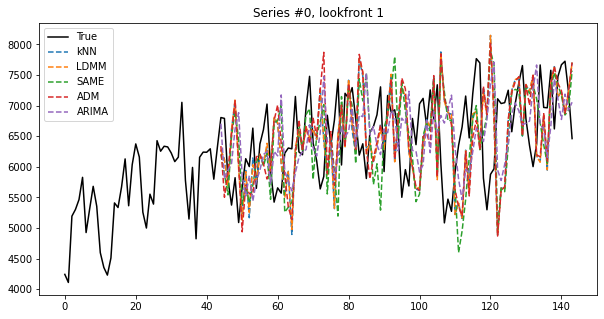

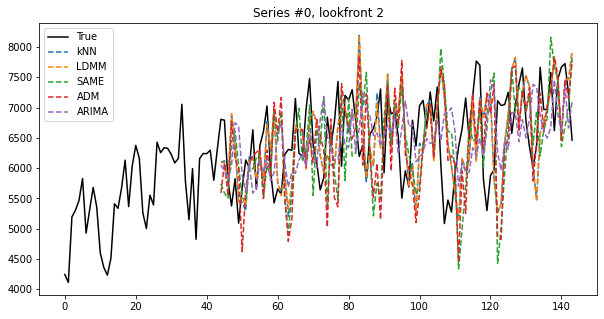

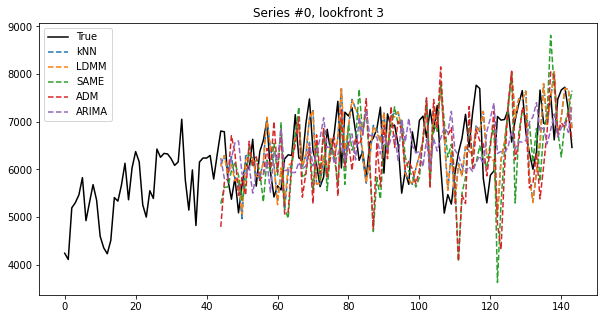

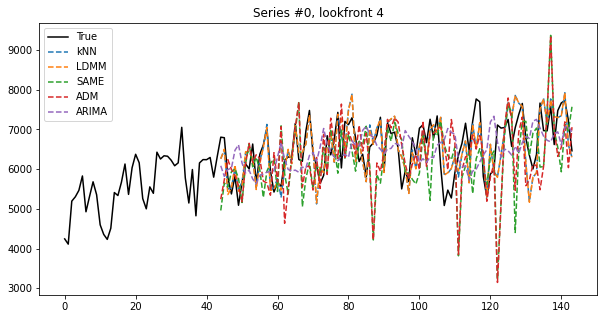

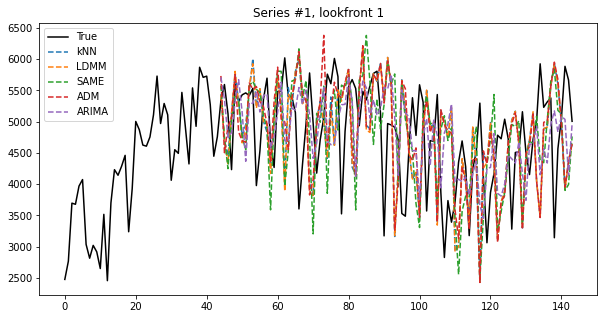

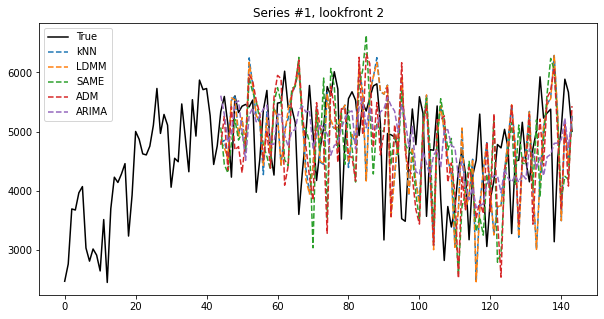

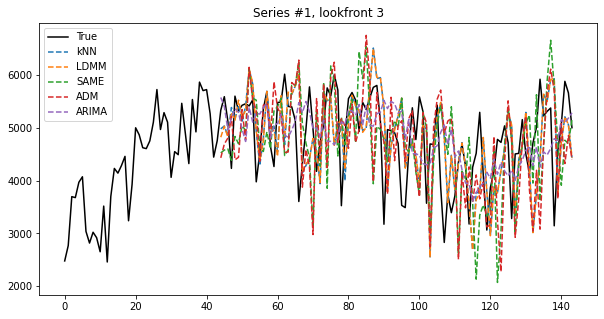

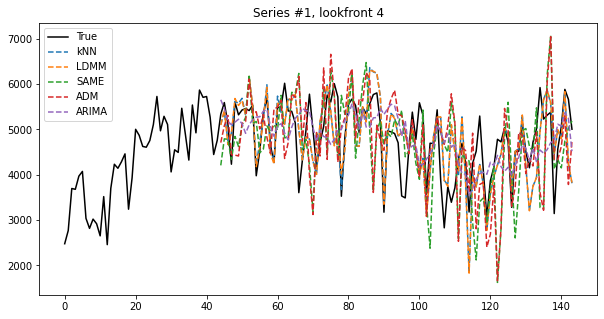

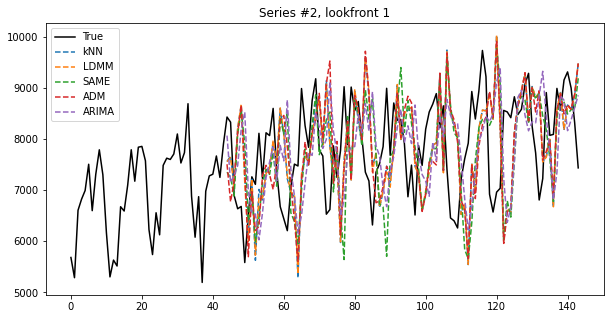

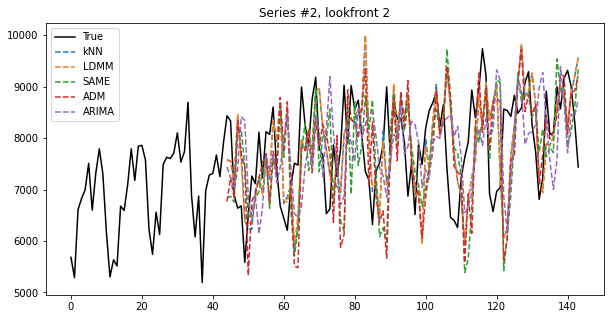

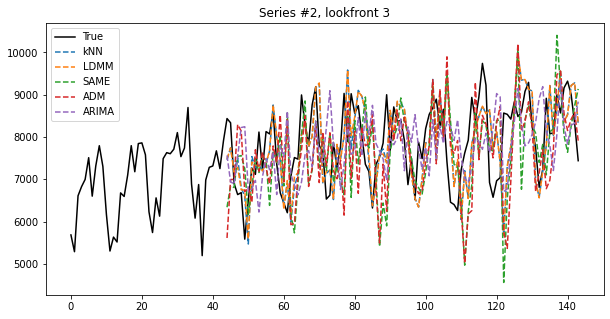

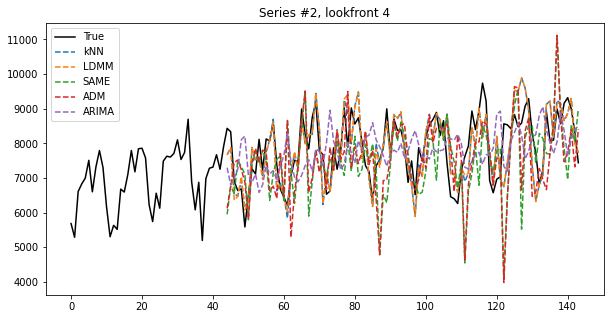

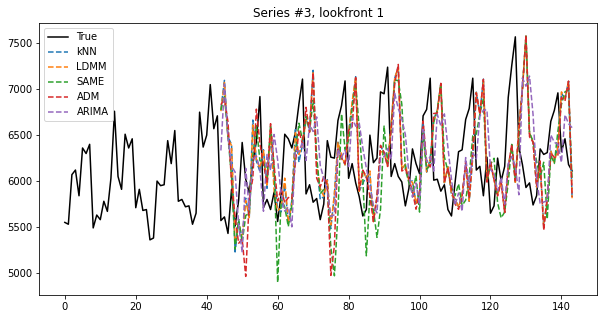

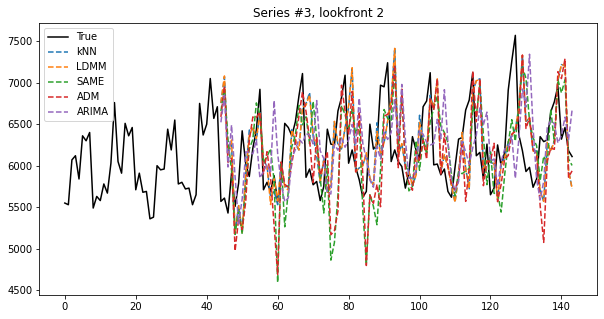

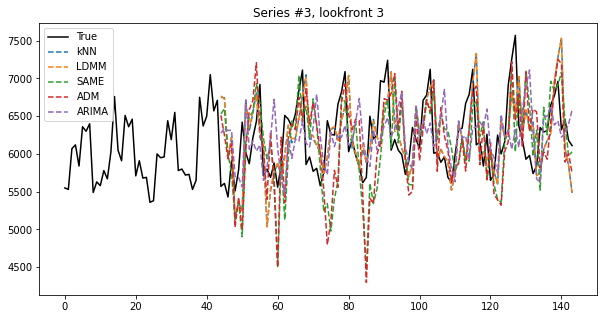

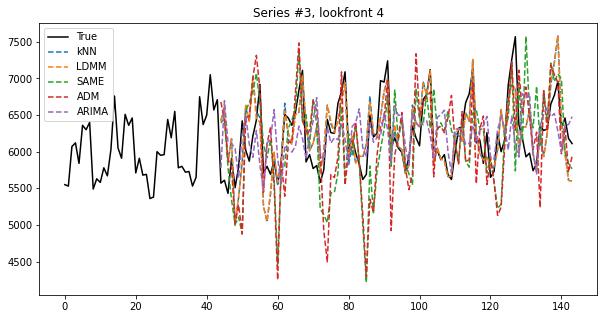

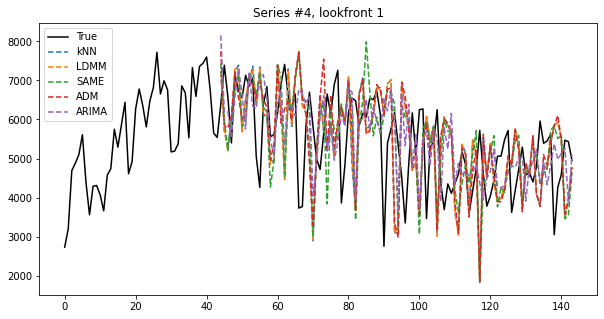

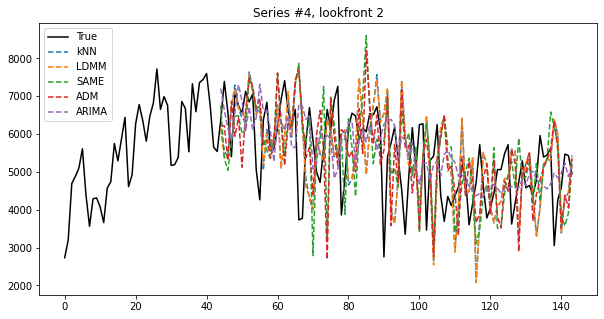

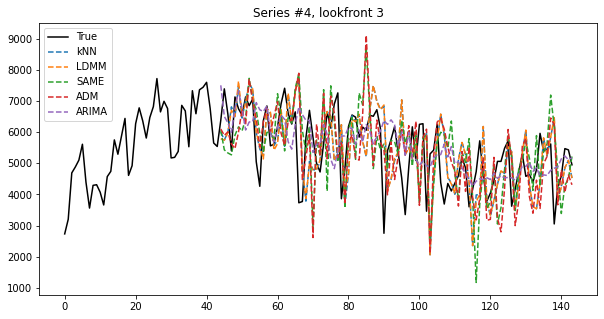

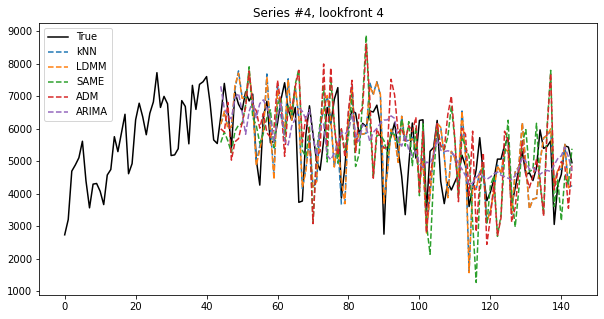

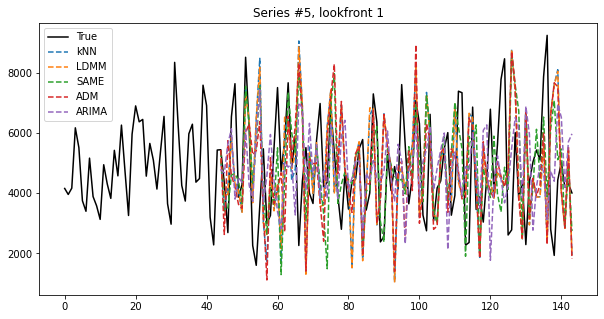

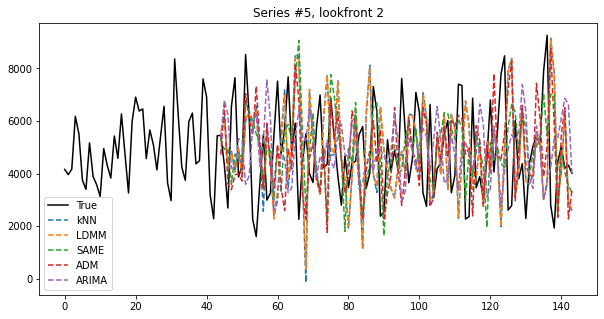

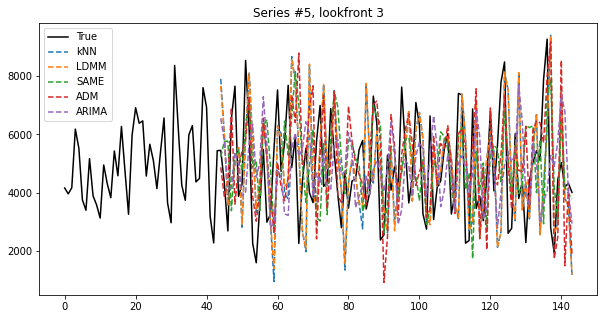

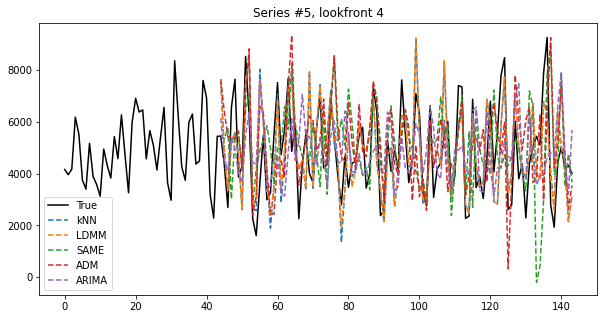

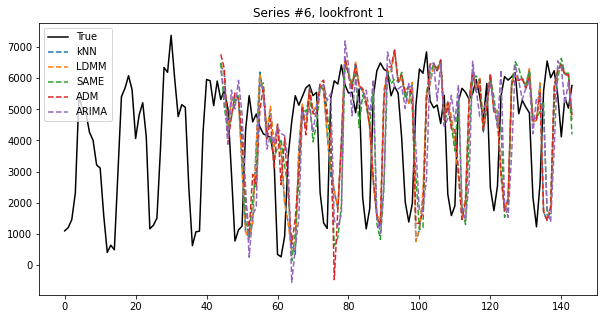

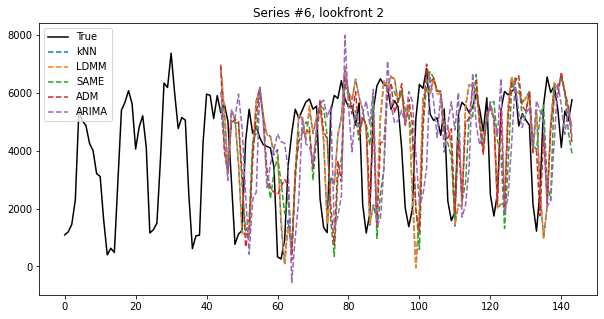

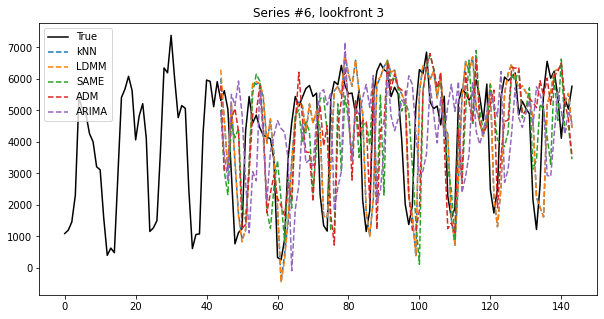

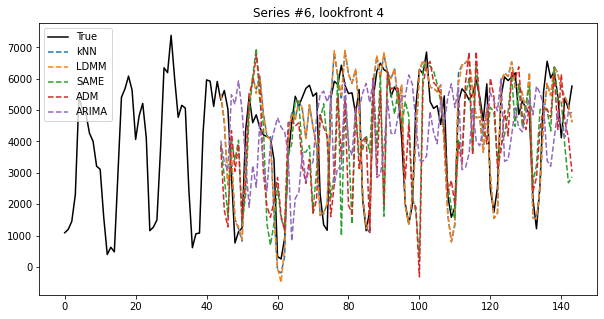

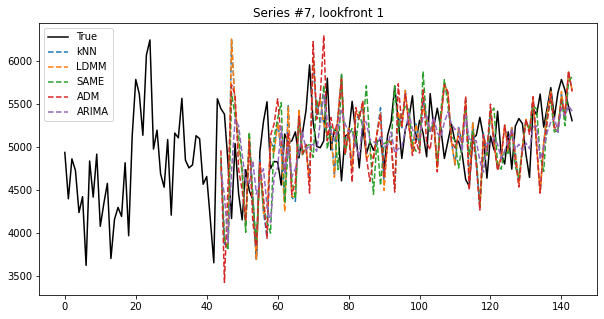

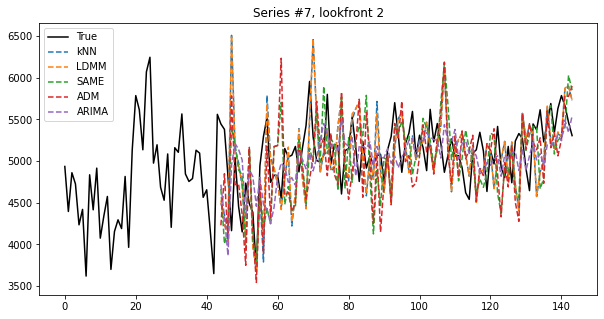

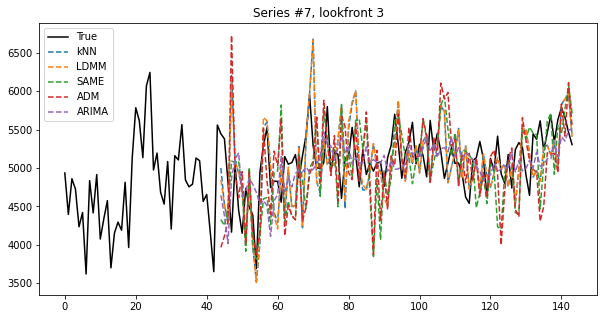

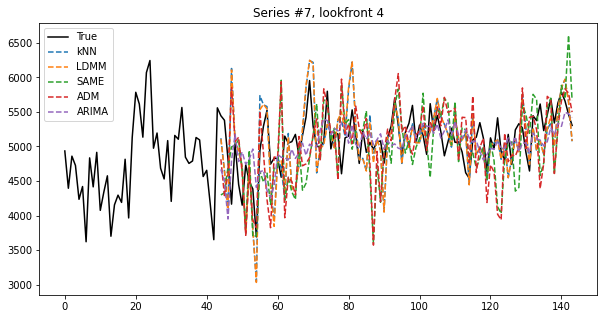

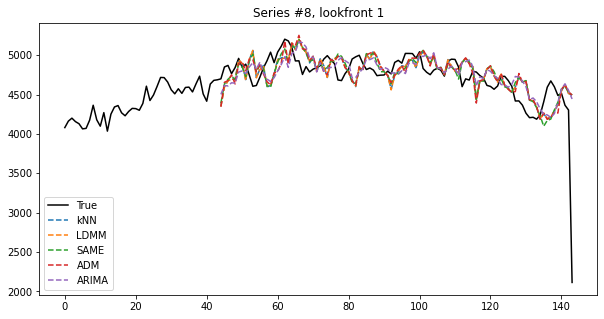

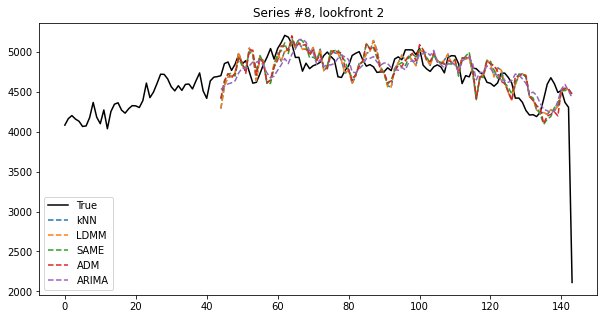

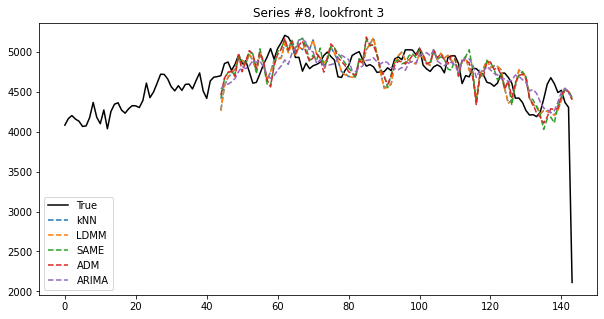

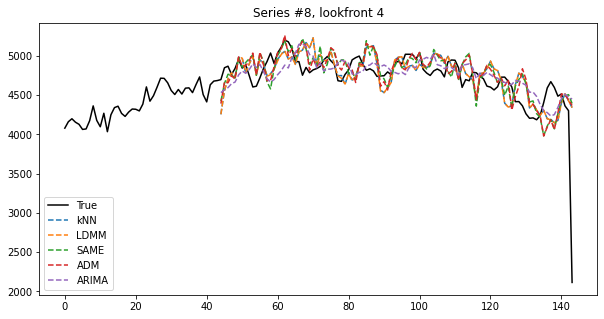

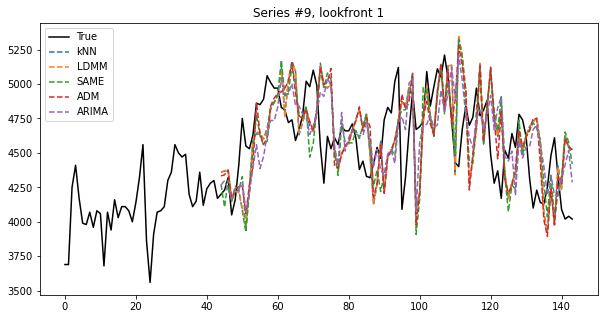

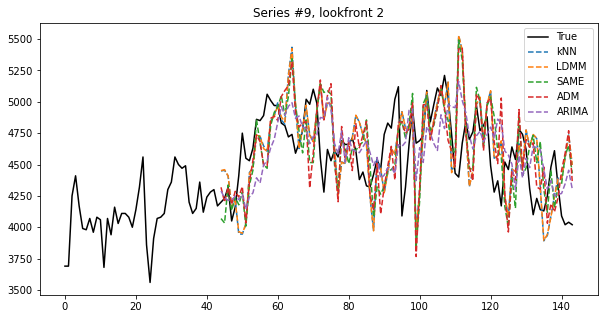

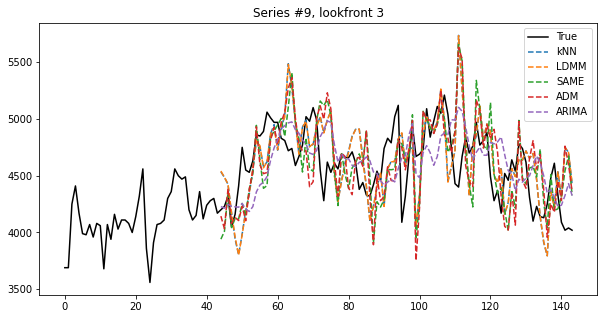

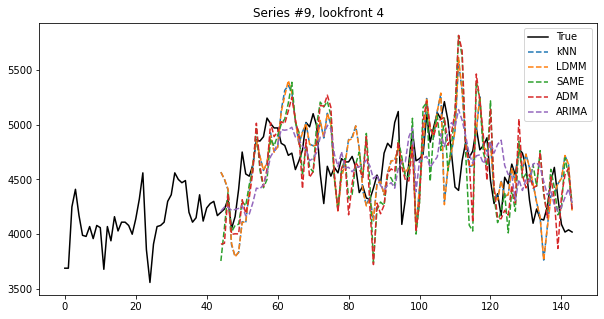

In [12]:
T = data.shape[0] - n_test
for series in range(data.shape[1]):
    for lookfront in lookfronts:
        fig = plt.figure(figsize=(10, 5))
        plt.plot(timestamps, data[:, series], 'k-', label='True')
        plt.plot(timestamps[-n_test:], predictions_knn[:, lookfront-1, series].reshape(-1), '--', label='kNN')
        plt.plot(timestamps[-n_test:], predictions_ldmm[:, lookfront-1, series].reshape(-1), '--', label='LDMM')
        plt.plot(timestamps[-n_test:], predictions_same[:, lookfront-1, series].reshape(-1), '--', label='SAME')
        plt.plot(timestamps[-n_test:], predictions_adm[:, lookfront-1, series].reshape(-1), '--', label='ADM')
        plt.plot(timestamps[-n_test:], predictions_arima[:, lookfront-1, series].reshape(-1), '--', label='ARIMA')
        plt.legend()
        # plt.xlabel('Timestamp')
        # plt.ylabel('Value')
        plt.title(f'Series #{series}, lookfront {lookfront}')
        plt.savefig(f'plots/nn3_series_{series}_lookfront_{lookfront}.pdf')
        
        plt.show()